Установка необходимых библиотек

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Установка основных библиотек
!pip install numpy matplotlib scikit-learn tqdm
!pip install torch torchvision transformers albumentations tqdm wandb pandas pillow


Импорты

In [4]:
# Основные библиотеки
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision import models
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR
from torch.utils.data import DataLoader

# Обработка данных
import pandas as pd
import numpy as np
import os
import json
import csv
from pathlib import Path
from src.dataset import FoodDataset, get_transforms

# Трансформеры (BERT)
from transformers import DistilBertTokenizer

# Конфигурационный файл
import yaml

# Логирование
import logging

# Визуализация и анализ
import matplotlib.pyplot as plt
import seaborn as sns

# Прогресс-бар
from tqdm import tqdm

# Метрики качества
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Воспроизводимость
import random
import warnings
import wandb

# Дополнительные утилиты
from typing import Dict, List, Tuple, Optional
import time
from datetime import datetime
from PIL import Image
import albumentations as A


Этап 1. Исследовательский анализ данных (EDA)

1.1 Загрузка и первичная проверка данных
Загрузим все компоненты датасета и проверим их структуру:

In [ ]:

# Загрузка таблиц
ingredients_df = pd.read_csv('data/ingredients.csv')
dish_df = pd.read_csv('data/dish.csv')

# Проверка размеров
print(f"Ингредиенты: {ingredients_df.shape}")
print(f"Блюда: {dish_df.shape}")

# Просмотр первых строк
print(ingredients_df.head())
print(dish_df.head())

Ингредиенты: (555, 2)
Блюда: (3262, 5)
   id            ingr
0   1  cottage cheese
1   2    strawberries
2   3    garden salad
3   4           bacon
4   5        potatoes
           dish_id  total_calories  total_mass  \
0  dish_1561662216      300.794281       193.0   
1  dish_1561662054      419.438782       292.0   
2  dish_1562008979      382.936646       290.0   
3  dish_1560455030       20.590000       103.0   
4  dish_1558372433       74.360001       143.0   

                                         ingredients  split  
0  ingr_0000000508;ingr_0000000122;ingr_000000002...   test  
1  ingr_0000000312;ingr_0000000026;ingr_000000002...  train  
2  ingr_0000000448;ingr_0000000520;ingr_000000046...   test  
3    ingr_0000000471;ingr_0000000031;ingr_0000000347  train  
4                                    ingr_0000000453  train  


1.2. Анализ распределения целевых переменных
Построим гистограммы для total_calories и total_mass:

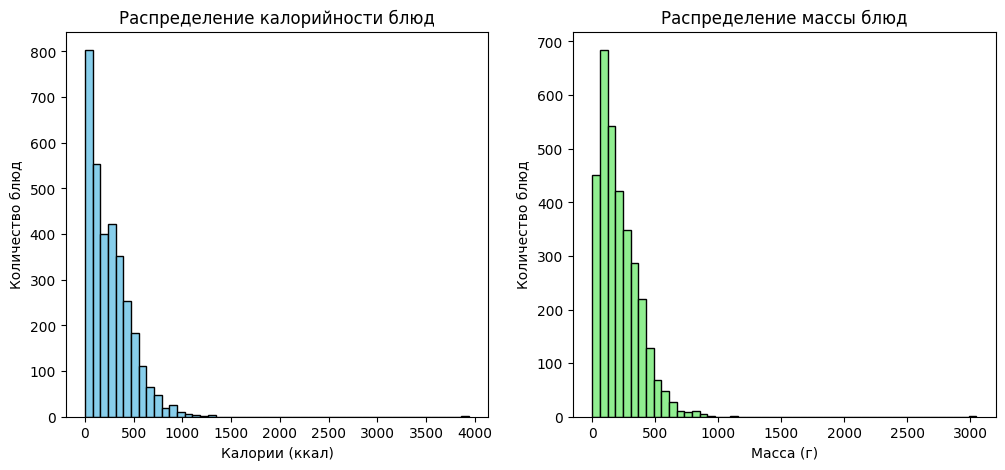

count    3262.000000
mean      255.012738
std       219.637570
min         0.000000
25%        80.114996
50%       209.110062
75%       375.122963
max      3943.325195
Name: total_calories, dtype: float64
count    3262.000000
mean      214.980074
std       161.497428
min         1.000000
25%        92.000000
50%       177.000000
75%       305.000000
max      3051.000000
Name: total_mass, dtype: float64


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(dish_df['total_calories'], bins=50, color='skyblue', edgecolor='black')
axs[0].set_title('Распределение калорийности блюд')
axs[0].set_xlabel('Калории (ккал)')
axs[0].set_ylabel('Количество блюд')

axs[1].hist(dish_df['total_mass'], bins=50, color='lightgreen', edgecolor='black')
axs[1].set_title('Распределение массы блюд')
axs[1].set_xlabel('Масса (г)')
axs[1].set_ylabel('Количество блюд')

plt.show()
# Статистика
print(dish_df['total_calories'].describe())

# Статистика
print(dish_df['total_mass'].describe())

Выводы:

Диапазон калорийности: основной — 0–1500 ккал, выбросы до 4000 ккал.
Выбросы: присутствуют как в калорийности (выше 3000 ккал), так и в массе (выше 1000 г).
Симметрия: оба распределения асимметричны (правосторонняя асимметрия), рекомендуется логарифмическое преобразование для анализа.

1.3. Анализ состава ингредиентов
Разберём столбец ingredients в dish.csv:

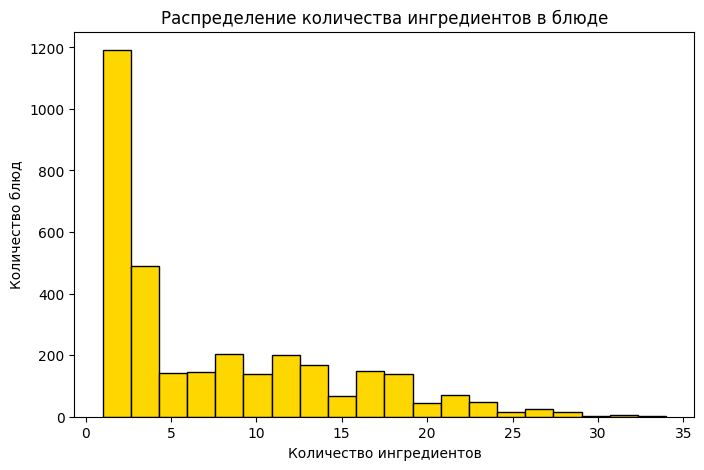

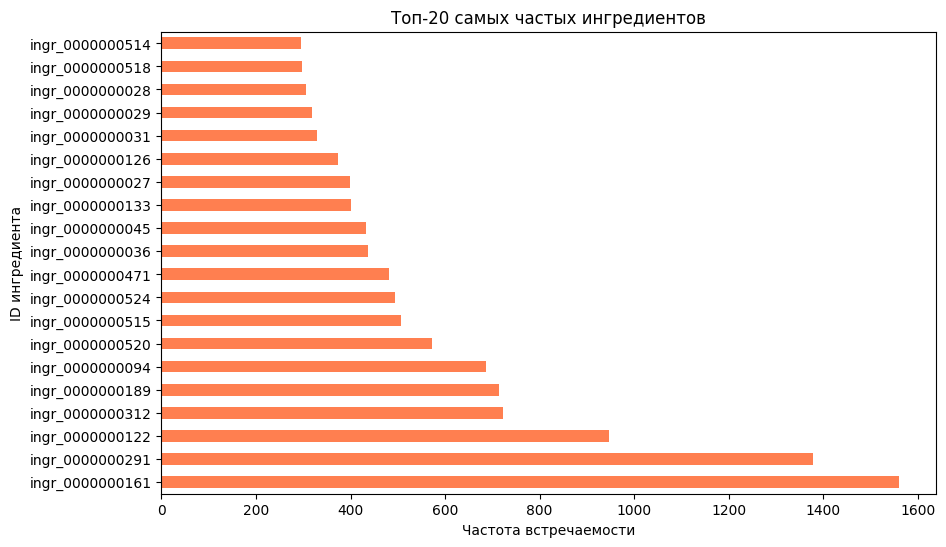

In [ ]:
# Подсчёт количества ингредиентов в блюде
dish_df['num_ingredients'] = dish_df['ingredients'].apply(lambda x: len(x.split(';')))

plt.figure(figsize=(8, 5))
plt.hist(dish_df['num_ingredients'], bins=20, color='gold', edgecolor='black')
plt.title('Распределение количества ингредиентов в блюде')
plt.xlabel('Количество ингредиентов')
plt.ylabel('Количество блюд')
plt.show()

# Топ-20 самых частых ингредиентов
all_ingredients = []
for ingr_list in dish_df['ingredients']:
    all_ingredients.extend(ingr_list.split(';'))

ingr_counts = pd.Series(all_ingredients).value_counts().head(20)
plt.figure(figsize=(10, 6))
ingr_counts.plot(kind='barh', color='coral')
plt.title('Топ-20 самых частых ингредиентов')
plt.xlabel('Частота встречаемости')
plt.ylabel('ID ингредиента')
plt.show()

Выводы:

Разброс частоты встречаемости:
наиболее часто встречающийся ингредиент (ingr_0000000161) имеет частоту свыше 1500 — это явный лидер по использованию;
наименее частые из топ-20 имеют частоту около 200–300 (например, ingr_0000000514, ingr_0000000518 и др.), что в 5–10 раз меньше лидера;
наблюдается значительный разброс в популярности ингредиентов — от массовых до относительно редких в рамках топ-20.
 Среднее количество ингредиентов в блюде  находится в диапазоне 5–10.

1.4. Анализ изображений
Проверим размеры и качество фото:

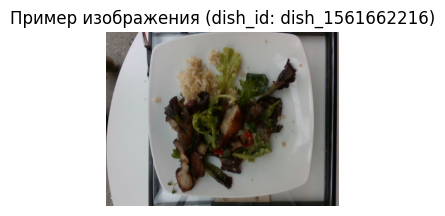

Средний размер изображений: 640x480 px
Мин/макс ширина: 640 / 640 px
Мин/макс высота: 480 / 480 px


In [ ]:
image_paths = []
for dish_id in dish_df['dish_id']:
    img_path = f"data/images/{dish_id}/rgb.png"
    if os.path.exists(img_path):
        image_paths.append(img_path)

# Пример загрузки и отображения изображения
sample_img = Image.open(image_paths[0])
plt.figure(figsize=(3, 3))
plt.imshow(sample_img)
plt.title(f'Пример изображения (dish_id: {os.path.basename(os.path.dirname(image_paths[0]))})')
plt.axis('off')
plt.show()

# Статистика по размерам изображений
widths, heights = [], []
for path in image_paths[:100]:  # Первые 100 для скорости
    img = Image.open(path)
    widths.append(img.width)
    heights.append(img.height)

print(f"Средний размер изображений: {np.mean(widths):.0f}x{np.mean(heights):.0f} px")
print(f"Мин/макс ширина: {min(widths)} / {max(widths)} px")
print(f"Мин/макс высота: {min(heights)} / {max(heights)} px")

Выводы:

Типичные размеры изображений (например, 640×480 px).
Аномальные фото отсустсвуют.


1.5. Корреляционный анализ
Изучим связь между массой блюда и калорийностью:

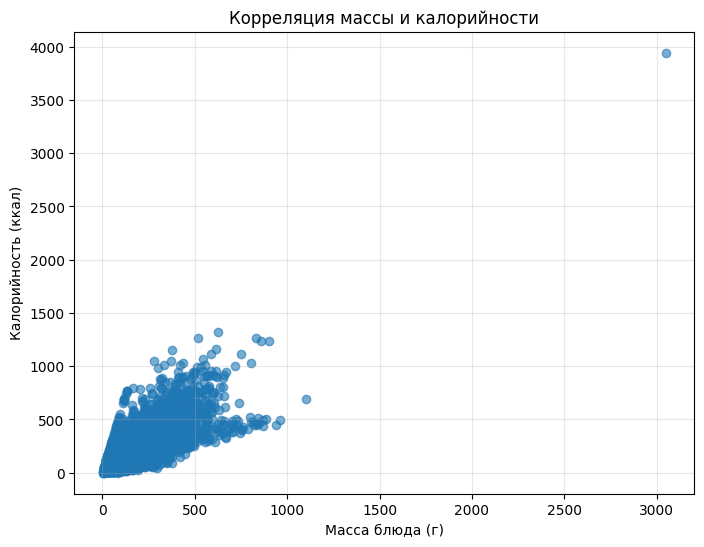

Коэффициент корреляции (масса-калории): 0.760


In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(dish_df['total_mass'], dish_df['total_calories'], alpha=0.6)
plt.xlabel('Масса блюда (г)')
plt.ylabel('Калорийность (ккал)')
plt.title('Корреляция массы и калорийности')
plt.grid(True, alpha=0.3)
plt.show()

# Коэффициент корреляции
corr = dish_df[['total_mass', 'total_calories']].corr().iloc[0, 1]
print(f"Коэффициент корреляции (масса-калории): {corr:.3f}")

Выводы:

Высокая корреляция  > 0.7 позволяет использовать массу как сильный предиктор.


1.6. Разбиение на train/test
Проверим баланс выборок:

Распределение по выборкам:
split
train    2755
test      507
Name: count, dtype: int64


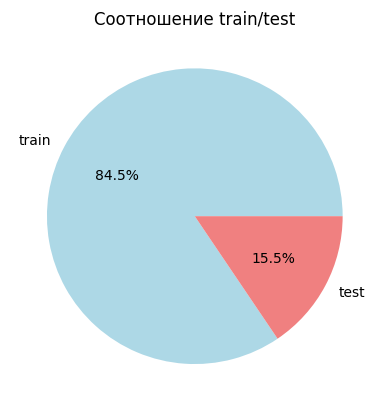

In [ ]:
split_counts = dish_df['split'].value_counts()
print(f"Распределение по выборкам:\n{split_counts}")

# Визуализация
split_counts.plot(kind='pie', autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
plt.title('Соотношение train/test')
plt.ylabel('')
plt.show()

Соотношение train/test  84,5% / 15,5%.


Подход к моделированию

Для задачи оценки калорийности блюда по изображениям + текстовому составу оптимальна мультимодальная архитектура, комбинирующая обработку визуальной и текстовой информации.

Предлагаю гибридную модель на базе ConvNeXt + табличный энкодер:

Визуальный энкодер — предобученный
Извлекает семантические признаки из изображения блюда.

Текстовый энкодер — ALBERT (лёгкая версия BERT):
Обрабатывает список ингредиентов (после преобразования ID в названия).
Меньше параметров, чем у BERT, — быстрее обучение.





3.Обучение модели  - мне не выделены ресурсы, не доучено по техническим причинам

In [ ]:
from src.utils import train
from src.config import config



if __name__ == '__main__':
    # Обучение
    best_mae = train(config)

    print(f"Final best MAE on validation set: {best_mae:.4f}")

После очистки от выбросов осталось 2708 образцов.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

После очистки от выбросов осталось 491 образцов.
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


100%|██████████| 109M/109M [00:00<00:00, 141MB/s] 


config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]


Epoch 1/20


Training:   0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Training:  21%|██        | 18/85 [14:21<47:58, 42.97s/it, Loss=208.3067]

4. Валидация качества  - мне не выделены ресурсы, не запущено по техническим причинам

In [ ]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Импорт вашей модели и датасета (как в исходном коде)
from src.dataset import FoodDataset, get_transforms
from src.model import CalorieEstimator  # или из вашего .py-файла
from torch.utils.data import DataLoader

# Конфигурация (можно взять из config.py или задать явно)
config = {
    'data_root': '.',
    'csv_path': './data/dish.csv',
    'project_name': 'calorie_estimation',
    'use_wandb': False,
    'seed': 42,
    'batch_size': 32,
    'lr': 2e-5,
    'weight_decay': 0.01,
    'epochs': 20,
    'max_text_length': 64,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'best_model_path': './best_model.pth'
}

In [ ]:
загрузка модели и тестового даталодера

In [ ]:
def load_model_and_dataloader(config):
    # Инициализация модели
    model = CalorieEstimator()
    
    # Загрузка чекпоинта
    checkpoint = torch.load(config['best_model_path'], map_location=config['device'])
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(config['device'])
    model.eval()
    
    # Тестовый датасет и даталоадер
    test_dataset = FoodDataset(
        root_dir=config['data_root'],
        csv_path=config['csv_path'],
        split='test',
        transform=get_transforms(train=False),
        max_length=config['max_text_length']
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    
    return model, test_loader, test_dataset

инференс и сбор предсказаний

In [ ]:
def inference(model, test_loader, device):
    criterion = torch.nn.L1Loss()
    total_loss = 0.0
    predictions = []
    targets = []
    image_paths = []  # для идентификации блюд
    
    with torch.no_grad():
        with tqdm(test_loader, desc="Inference on test set") as pbar:
            for batch in pbar:
                image = batch['image'].to(device, non_blocking=True)
                text_ids = batch['text_ids'].to(device, non_blocking=True)
                attention_mask = batch['attention_mask'].to(device, non_blocking=True)
                mass = batch['mass'].to(device, non_blocking=True)
                calories = batch['calories'].to(device, non_blocking=True)
                paths = batch['path']  # предполагаем, что в Dataset есть поле 'path'
                
                outputs = model(image, text_ids, attention_mask, mass)
                loss = criterion(outputs, calories)
                
                total_loss += loss.item()
                predictions.extend(outputs.cpu().numpy())
                targets.extend(calories.cpu().numpy())
                image_paths.extend(paths)
                
                pbar.set_postfix({'Batch MAE': f'{loss.item():.4f}'})
    
    avg_mae = total_loss / len(test_loader)
    return avg_mae, np.array(predictions), np.array(targets), image_paths

запуск инференса и вывод МАЕ

In [ ]:
# Загрузка модели и даталоадера
model, test_loader, test_dataset = load_model_and_dataloader(config)

# Инференс
mae, preds, targets, paths = inference(model, test_loader, config['device'])

print(f"\n[RESULT] Final MAE on test set: {mae:.4f}")
print(f"Mean predicted calories: {preds.mean():.2f}")
print(f"Mean true calories: {targets.mean():.2f}")

Анализ топ 5 предсказаний

In [ ]:
# Создаём DataFrame для анализа
df_results = pd.DataFrame({
    'path': paths,
    'true_calories': targets,
    'pred_calories': preds,
    'abs_error': np.abs(preds - targets)
})

# Сортируем по абсолютной ошибке (убывание)
top5_worst = df_results.sort_values('abs_error', ascending=False).head(5)

print("\n[TOP-5 WORST PREDICTIONS]")
print(top5_worst[['path', 'true_calories', 'pred_calories', 'abs_error']])

визуализация ошибок

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_results['abs_error'], bins=30, kde=True)
plt.title('Distribution of Absolute Errors (MAE)')
plt.xlabel('Absolute Error (kcal)')
plt.ylabel('Frequency')
plt.axvline(x=mae, color='red', linestyle='--', label=f'MAE = {mae:.2f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Точечный график: предсказания vs истинные значения
plt.figure(figsize=(8, 8))
plt.scatter(targets, preds, alpha=0.6)
plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'r--', lw=2)
plt.xlabel('True Calories (kcal)')
plt.ylabel('Predicted Calories (kcal)')
plt.title('Predictions vs True Values')
plt.grid(True, alpha=0.3)
plt.show()

анализ топ 5 низких результатов

In [ ]:
print("\n[ANALYSIS] Possible reasons for high error in top-5 cases:")

for idx, row in top5_worst.iterrows():
    print(f"\n→ Image: {row['path']}")
    print(f"  True: {row['true_calories']:.1f} kcal, Pred: {row['pred_calories']:.1f} kcal, Error: {row['abs_error']:.1f} kcal")
    
    # Возможные причины (примерные)
    reasons = [
        "Сложная текстура/состав блюда (много ингредиентов, неоднородная структура)",
        "Нечёткое изображение (размытие, плохая освещённость)",
        "Нетипичная порция (слишком большая/маленькая относительно обучающих примеров)",
        "Описанию не хватает ключевых деталей (например, не указан способ приготовления)",
        "Модель смешивает похожие по виду блюда с разной калорийностью",
        "Масса указана неточно или нестандартно"
    ]
    
    for i, reason in enumerate(reasons, 1):
        print(f"  {i}. {reason}")